In [2]:
import torch
import torch.optim as optim
from PIL import Image
from pathlib import Path
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import numpy as np


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
BATCH_SIZE = 32
PATIENCE=5
IMG_HEIGHT = 384
IMG_WIDTH = 512
EPOCHS=20
NUM_CLASSES=6
LEARNING_RATE=0.0001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Using device: {DEVICE}')

Using device: cuda


In [6]:
data_path = Path("Garbage classification")

# transformations for training data 
train_transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),  # Random zoom effect
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=20),  # Shear transformation
    transforms.ToTensor(),
])

# transformations for validation data 
val_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
])


full_dataset = datasets.ImageFolder(data_path, transform=train_transform)

# Split dataset (80/20 split)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


val_dataset.dataset.transform = val_transform


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


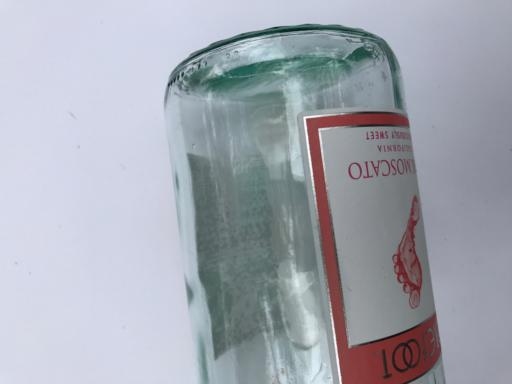

In [32]:
glass_data = list(data_path.glob('glass/*')) 
img_path = glass_data[3]
img = Image.open(img_path)
img

In [33]:
# Load pretrained MobileNetV2
base_model = models.mobilenet_v2(pretrained=True)
base_model.classifier[1] = torch.nn.Linear(base_model.classifier[1].in_features, NUM_CLASSES)
base_model = base_model.to(DEVICE)

# Print model architecture
print(base_model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

c:\Users\yassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
# loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(base_model.parameters(), lr=LEARNING_RATE)


In [35]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=EPOCHS, patience=PATIENCE):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    best_val_acc = 0.0
    counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss, correct_preds = 0.0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_preds.double() / len(train_loader.dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc.item())

        # Validation phase
        model.eval()
        val_running_loss, val_correct_preds = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct_preds += torch.sum(preds == labels)

        val_loss_epoch = val_running_loss / len(val_loader.dataset)
        val_acc_epoch = val_correct_preds.double() / len(val_loader.dataset)
        val_loss.append(val_loss_epoch)
        val_acc.append(val_acc_epoch.item())

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss_epoch:.4f}, Val Acc: {val_acc_epoch:.4f}")

        # Early stopping
        if val_acc_epoch > best_val_acc:
            best_val_acc = val_acc_epoch
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

    return train_loss, val_loss, train_acc, val_acc

In [36]:
# Train the model
train_loss, val_loss, train_acc, val_acc = train_model(base_model, criterion, optimizer, train_loader, val_loader)


Epoch 1/20, Train Loss: 0.8535, Train Acc: 0.7180, Val Loss: 0.3509, Val Acc: 0.9032
Epoch 2/20, Train Loss: 0.3147, Train Acc: 0.9035, Val Loss: 0.2352, Val Acc: 0.9130
Epoch 3/20, Train Loss: 0.1437, Train Acc: 0.9624, Val Loss: 0.1786, Val Acc: 0.9308
Epoch 4/20, Train Loss: 0.0943, Train Acc: 0.9767, Val Loss: 0.1767, Val Acc: 0.9387
Epoch 5/20, Train Loss: 0.0618, Train Acc: 0.9886, Val Loss: 0.1372, Val Acc: 0.9466
Epoch 6/20, Train Loss: 0.0298, Train Acc: 0.9975, Val Loss: 0.1363, Val Acc: 0.9545
Epoch 7/20, Train Loss: 0.0256, Train Acc: 0.9975, Val Loss: 0.1207, Val Acc: 0.9526
Epoch 8/20, Train Loss: 0.0237, Train Acc: 0.9960, Val Loss: 0.1410, Val Acc: 0.9506
Epoch 9/20, Train Loss: 0.0163, Train Acc: 0.9970, Val Loss: 0.1570, Val Acc: 0.9427
Epoch 10/20, Train Loss: 0.0132, Train Acc: 0.9985, Val Loss: 0.1485, Val Acc: 0.9466
Epoch 11/20, Train Loss: 0.0121, Train Acc: 0.9980, Val Loss: 0.1394, Val Acc: 0.9526
Early stopping triggered.


In [37]:
# Save the entire model
torch.save(base_model, 'Garbage_classification.pth')

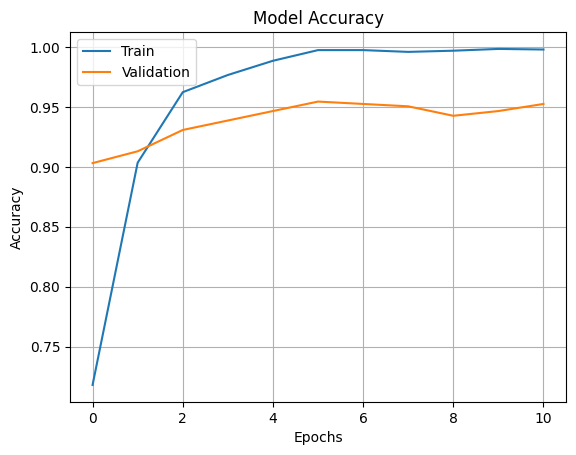

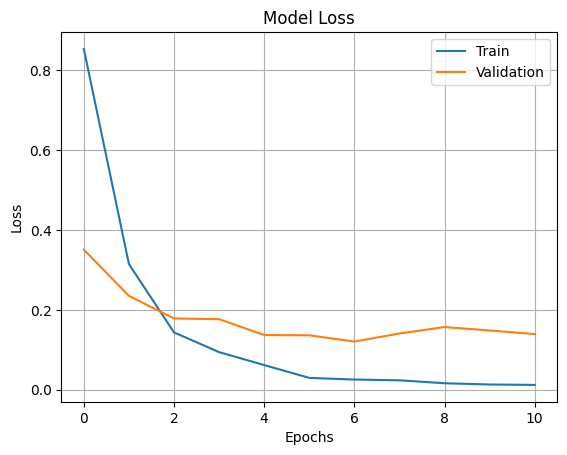

In [38]:
# Plot accuracy and loss
def plot_metrics(train_metric, val_metric, metric_name='Accuracy'):
    plt.plot(train_metric, label='Train')
    plt.plot(val_metric, label='Validation')
    plt.title(f'Model {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot accuracy and loss
plot_metrics(train_acc, val_acc, 'Accuracy')
plot_metrics(train_loss, val_loss, 'Loss')


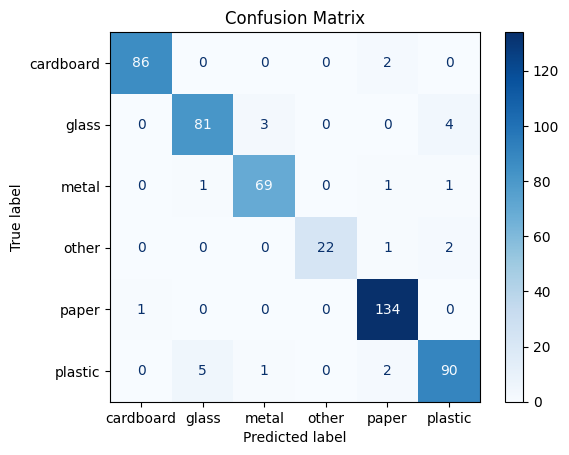

In [40]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
    return all_preds, all_labels

# Get predictions and labels
y_pred, y_true = evaluate_model(base_model, val_loader)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [4]:
base_model = torch.load('Garbage_classification.pth')  # Load the piece classification model
mobase_modeldel = base_model.to(DEVICE)  # Move model to the specified device
# print("Piece model loaded successfully!")  # Confirmation message

C:\Users\yassi\AppData\Local\Temp\ipykernel_16508\2183253746.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model = torch.load('Garbage_classification.pth')  # Loa

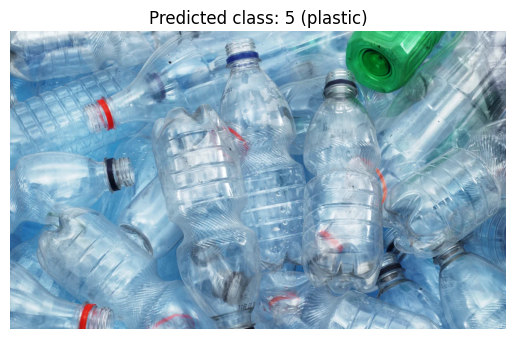

In [14]:
from PIL import Image
import torchvision.transforms as transforms
import torch

# Specify the image path
image_path = "test.png"  # Replace with your image path

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
])

# Load and preprocess the image
image = Image.open(image_path).convert("RGB")

plt.imshow(image)
image = transform(image)
image = image.unsqueeze(0)  # Add a batch dimension
image = image.to(DEVICE)    # Move to the appropriate device

# Set the model to evaluation mode and get predictions
base_model.eval()
with torch.no_grad():
    outputs = base_model(image)
    _, preds = torch.max(outputs, 1)

# Get the predicted class
predicted_class = preds.item()
result=(f"Predicted class: {predicted_class} ({train_dataset.dataset.classes[predicted_class]})")
plt.axis("off")
plt.title(result)
plt.show()
